In [1]:

import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from IPython.display import display, clear_output
from glob import glob
%matplotlib inline





In [2]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
hands = mp_hands.Hands(min_detection_confidence=1.0, min_tracking_confidence=0.7)

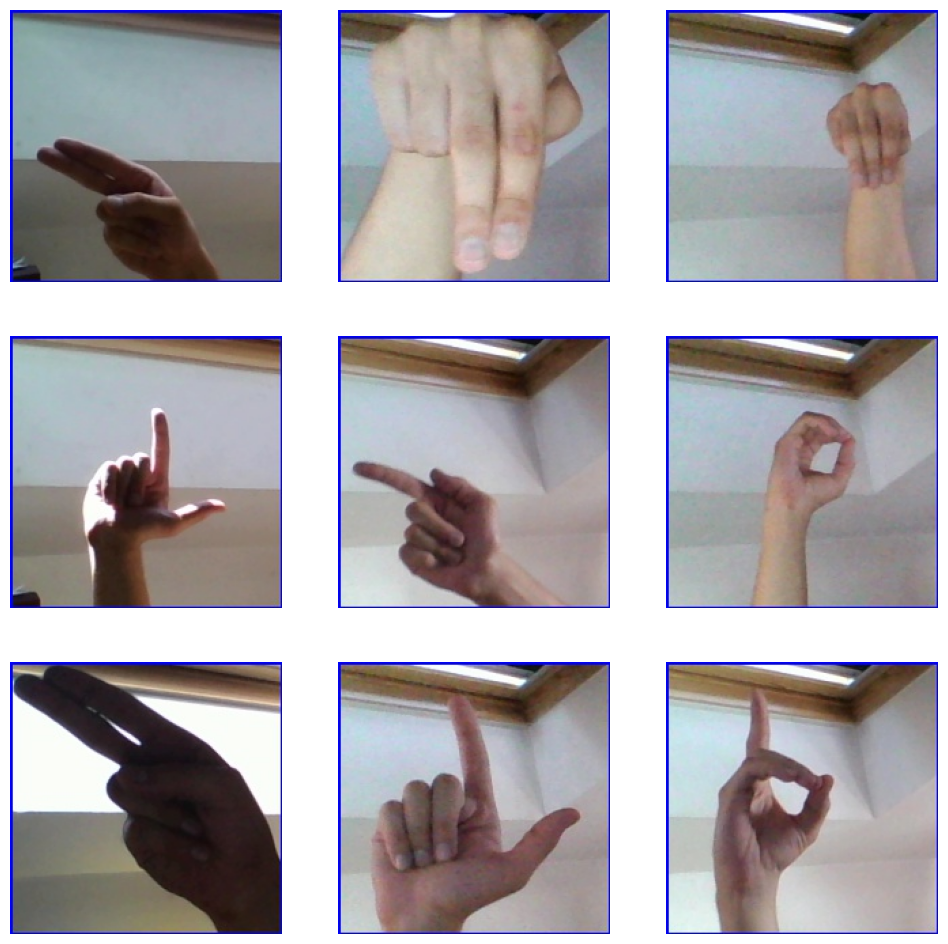

In [3]:

images = glob("asl_alphabet_train/**/*.jpg", recursive=True) + \
         glob("asl_alphabet_train/**/*.jpeg", recursive=True) + \
         glob("asl_alphabet_train/**/*.png", recursive=True)

images = [img for img in images if os.path.isfile(img)]
plt.figure(figsize=(12, 12))
for i in range(9):
        image = random.choice(images)
        img = cv2.imread(image)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(3, 3, i+1)
            plt.imshow(img_rgb)
            plt.axis('off')
        
plt.show()


In [11]:
img_size =48
batch_size=64
datagen_train = ImageDataGenerator()
train_generator= datagen_train.flow_from_directory("asl_alphabet_train/",
                                                   target_size =(img_size,img_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="sparse",
                                                   shuffle=True)
datagen_validation = ImageDataGenerator()
validation_generator= datagen_train.flow_from_directory("asl_alphabet_test/",
                                                   target_size =(img_size,img_size),
                                                   color_mode="grayscale",
                                                   batch_size=batch_size,
                                                   class_mode="sparse",
                                                   shuffle=True)

Found 45789 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [12]:



def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3, 3))
    conv_2 = Convolution(conv_1, 64, (5, 5))
    conv_3 = Convolution(conv_2, 128, (6, 6))
    flatten = Flatten()(conv_3)
    dense_1 = Dense(256, activation='relu')(flatten)
    output = Dense(7, activation="softmax")(dense_1)
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = model_fer((48, 48, 1))

model.summary()





Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,529,223 (5.83 MB)

 Trainable params: 1,528,775 (5.83 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

epochs= 15
steps_per_epoch= train_generator.n//train_generator.batch_size
validation_steps= validation_generator.n//validation_generator.batch_size
checkpoint= ModelCheckpoint("model_weights.weights.h5",monitor = 'val_accuracy', save_weights_only= True, mode='max', verbose=1)
callbacks=[checkpoint]

In [14]:
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/15


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9902 - loss: 0.0299
Epoch 1: saving model to model_weights.weights.h5
715/715 ━━━━━━━━━━━━━━━━━━━━ 850s 1s/step - accuracy: 0.9902 - loss: 0.0299 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
  1/715 ━━━━━━━━━━━━━━━━━━━━ 7:12 606ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: saving model to model_weights.weights.h5


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: saving model to model_weights.weights.h5
715/715 ━━━━━━━━━━━━━━━━━━━━ 423s 590ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
  1/715 ━━━━━━━━━━━━━━━━━━━━ 7:01 590ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 4: saving model to model_weights.weights.h5
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 5: saving model to model_weights.weights.h5
715/715 ━━━━━━━━━━━━━━━━━━━━ 413s 577ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
  1/715 ━━━━━━━━━━━━━━━━━━━━ 6:26 541ms/step - ac

In [15]:
model.evaluate(validation_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step - accuracy: 1.0000 - loss: 0.0000e+00


[0.0, 1.0]

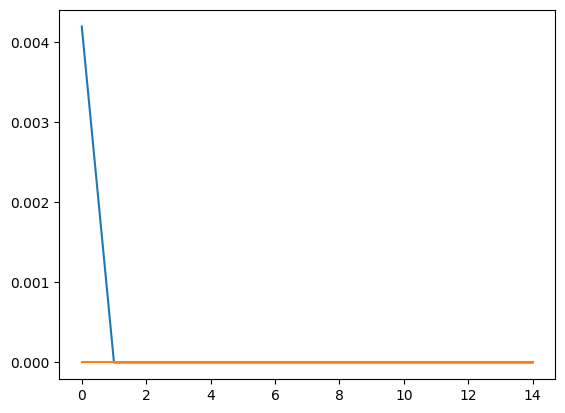

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')